# "Holding Constant" Made Visual

**Business Question**: How do penguin body measurements relate to each other?

This notebook demonstrates the concept of "holding constant" in multiple regression by visualizing how the effect of one predictor changes when we control for another predictor. We'll use penguin body measurements to make this abstract concept concrete and visual.


## Learning Objectives

By the end of this notebook, you will be able to:
- Understand what "holding constant" means in multiple regression
- Visualize partial effects through 3D plots and slices
- Compare simple vs multiple regression coefficients
- Interpret why coefficients change when adding predictors
- See how Simpson's paradox can occur in real data


In [1]:
# Import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
from statsmodels.formula.api import ols
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")


## Data Exploration


In [2]:
# Load penguins dataset
penguins = sns.load_dataset('penguins')

# Clean data (remove missing values)
penguins_clean = penguins.dropna()

print("Dataset shape:", penguins_clean.shape)
print("\nFirst 5 rows:")
print(penguins_clean.head())
print("\nSpecies distribution:")
print(penguins_clean['species'].value_counts())

# Focus on numerical variables
numerical_vars = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
print(f"\nNumerical variables: {numerical_vars}")
print("\nBasic statistics:")
print(penguins_clean[numerical_vars].describe())


Dataset shape: (333, 7)

First 5 rows:
  species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen            39.1           18.7              181.0   
1  Adelie  Torgersen            39.5           17.4              186.0   
2  Adelie  Torgersen            40.3           18.0              195.0   
4  Adelie  Torgersen            36.7           19.3              193.0   
5  Adelie  Torgersen            39.3           20.6              190.0   

   body_mass_g     sex  
0       3750.0    Male  
1       3800.0  Female  
2       3250.0  Female  
4       3450.0  Female  
5       3650.0    Male  

Species distribution:
species
Adelie       146
Gentoo       119
Chinstrap     68
Name: count, dtype: int64

Numerical variables: ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']

Basic statistics:
       bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g
count      333.000000     333.000000         333.000000   333.000000
mean   

## Step 1: Simple Regression First


Simple Regression: Body Mass ~ Flipper Length
                            OLS Regression Results                            
Dep. Variable:            body_mass_g   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     1060.
Date:                Sat, 18 Oct 2025   Prob (F-statistic):          3.13e-105
Time:                        14:41:19   Log-Likelihood:                -2461.1
No. Observations:                 333   AIC:                             4926.
Df Residuals:                     331   BIC:                             4934.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

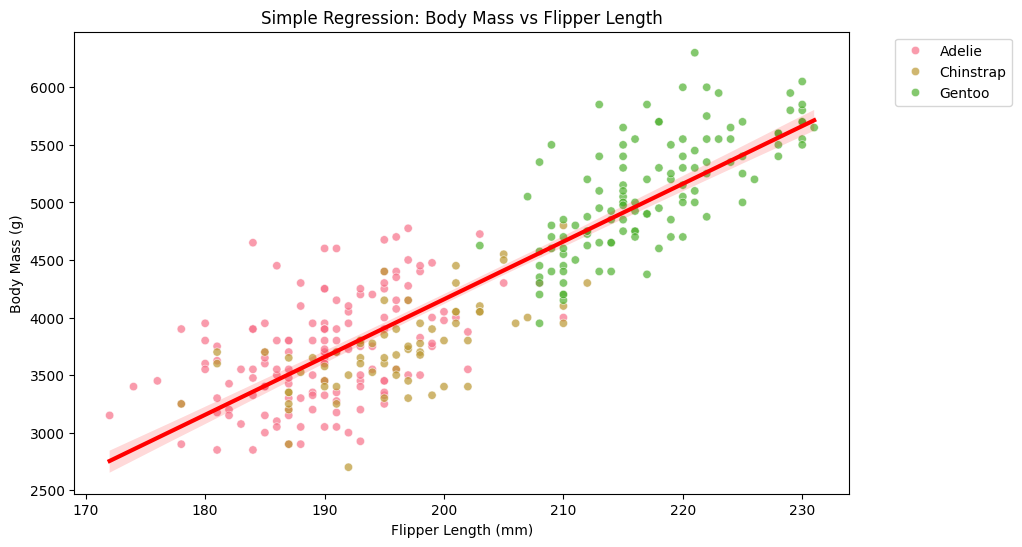


Simple regression coefficient: 50.15
Interpretation: Each 1mm increase in flipper length → 50.2g increase in body mass


In [3]:
# Simple regression: body_mass_g ~ flipper_length_mm
simple_model = ols("body_mass_g ~ flipper_length_mm", data=penguins_clean).fit()

print("Simple Regression: Body Mass ~ Flipper Length")
print("="*50)
print(simple_model.summary())

# Visualize simple regression
plt.figure(figsize=(10, 6))
sns.scatterplot(data=penguins_clean, x='flipper_length_mm', y='body_mass_g', 
                hue='species', alpha=0.7)
sns.regplot(data=penguins_clean, x='flipper_length_mm', y='body_mass_g', 
            scatter=False, color='red', line_kws={'linewidth': 3})
plt.title('Simple Regression: Body Mass vs Flipper Length')
plt.xlabel('Flipper Length (mm)')
plt.ylabel('Body Mass (g)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

print(f"\nSimple regression coefficient: {simple_model.params['flipper_length_mm']:.2f}")
print("Interpretation: Each 1mm increase in flipper length → {:.1f}g increase in body mass".format(
    simple_model.params['flipper_length_mm']))


## Step 2: Add Second Predictor


In [4]:
# Multiple regression: body_mass_g ~ flipper_length_mm + bill_depth_mm
multiple_model = ols("body_mass_g ~ flipper_length_mm + bill_depth_mm", data=penguins_clean).fit()

print("Multiple Regression: Body Mass ~ Flipper Length + Bill Depth")
print("="*60)
print(multiple_model.summary())

# Compare coefficients
print("\nCoefficient Comparison:")
print("="*40)
print(f"Simple regression (flipper only): {simple_model.params['flipper_length_mm']:.2f}")
print(f"Multiple regression (flipper):    {multiple_model.params['flipper_length_mm']:.2f}")
print(f"Multiple regression (bill depth): {multiple_model.params['bill_depth_mm']:.2f}")

# Show how coefficients changed
flipper_change = multiple_model.params['flipper_length_mm'] - simple_model.params['flipper_length_mm']
print(f"\nFlipper coefficient changed by: {flipper_change:.2f}")
print("This is the 'holding constant' effect!")


Multiple Regression: Body Mass ~ Flipper Length + Bill Depth
                            OLS Regression Results                            
Dep. Variable:            body_mass_g   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     533.2
Date:                Sat, 18 Oct 2025   Prob (F-statistic):          4.28e-104
Time:                        14:41:19   Log-Likelihood:                -2460.0
No. Observations:                 333   AIC:                             4926.
Df Residuals:                     330   BIC:                             4937.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------

## Step 3: The Magic - "Holding Constant" Visualization


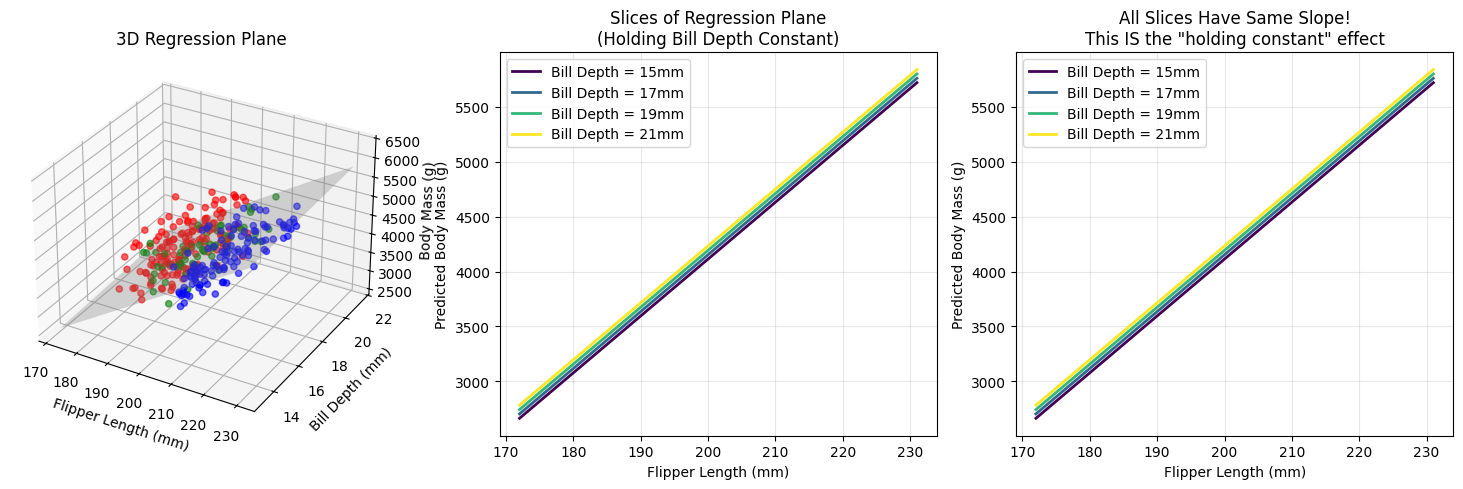

Key Insight: All slices have the same slope!
This slope (51.77) is the partial effect of flipper length,
controlling for (holding constant) bill depth.


In [5]:
# Create 3D visualization of the regression plane
fig = plt.figure(figsize=(15, 5))

# 3D scatter plot with regression plane
ax1 = fig.add_subplot(131, projection='3d')

# Scatter plot
x = penguins_clean['flipper_length_mm']
y = penguins_clean['bill_depth_mm'] 
z = penguins_clean['body_mass_g']
colors = ['red' if s == 'Adelie' else 'blue' if s == 'Gentoo' else 'green' 
          for s in penguins_clean['species']]

ax1.scatter(x, y, z, c=colors, alpha=0.6)

# Create regression plane
xx, yy = np.meshgrid(np.linspace(x.min(), x.max(), 20), 
                     np.linspace(y.min(), y.max(), 20))
zz = (multiple_model.params['Intercept'] + 
      multiple_model.params['flipper_length_mm'] * xx + 
      multiple_model.params['bill_depth_mm'] * yy)

ax1.plot_surface(xx, yy, zz, alpha=0.3, color='gray')
ax1.set_xlabel('Flipper Length (mm)')
ax1.set_ylabel('Bill Depth (mm)')
ax1.set_zlabel('Body Mass (g)')
ax1.set_title('3D Regression Plane')

# Show slices of the plane at different bill_depth values
ax2 = fig.add_subplot(132)
bill_depth_values = [15, 17, 19, 21]  # Different bill depths to slice at
colors_slice = plt.cm.viridis(np.linspace(0, 1, len(bill_depth_values)))

for i, depth in enumerate(bill_depth_values):
    # Create data at this bill depth
    flipper_range = np.linspace(x.min(), x.max(), 100)
    predicted_mass = (multiple_model.params['Intercept'] + 
                     multiple_model.params['flipper_length_mm'] * flipper_range + 
                     multiple_model.params['bill_depth_mm'] * depth)
    
    ax2.plot(flipper_range, predicted_mass, 
             color=colors_slice[i], linewidth=2, 
             label=f'Bill Depth = {depth}mm')

ax2.set_xlabel('Flipper Length (mm)')
ax2.set_ylabel('Predicted Body Mass (g)')
ax2.set_title('Slices of Regression Plane\n(Holding Bill Depth Constant)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Show the key insight: all slices have the same slope
ax3 = fig.add_subplot(133)
for i, depth in enumerate(bill_depth_values):
    flipper_range = np.linspace(x.min(), x.max(), 100)
    predicted_mass = (multiple_model.params['Intercept'] + 
                     multiple_model.params['flipper_length_mm'] * flipper_range + 
                     multiple_model.params['bill_depth_mm'] * depth)
    
    ax3.plot(flipper_range, predicted_mass, 
             color=colors_slice[i], linewidth=2, 
             label=f'Bill Depth = {depth}mm')

ax3.set_xlabel('Flipper Length (mm)')
ax3.set_ylabel('Predicted Body Mass (g)')
ax3.set_title('All Slices Have Same Slope!\nThis IS the "holding constant" effect')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Key Insight: All slices have the same slope!")
print(f"This slope ({multiple_model.params['flipper_length_mm']:.2f}) is the partial effect of flipper length,")
print("controlling for (holding constant) bill depth.")


## Step 4: Simpson's Paradox - Why Coefficients Change


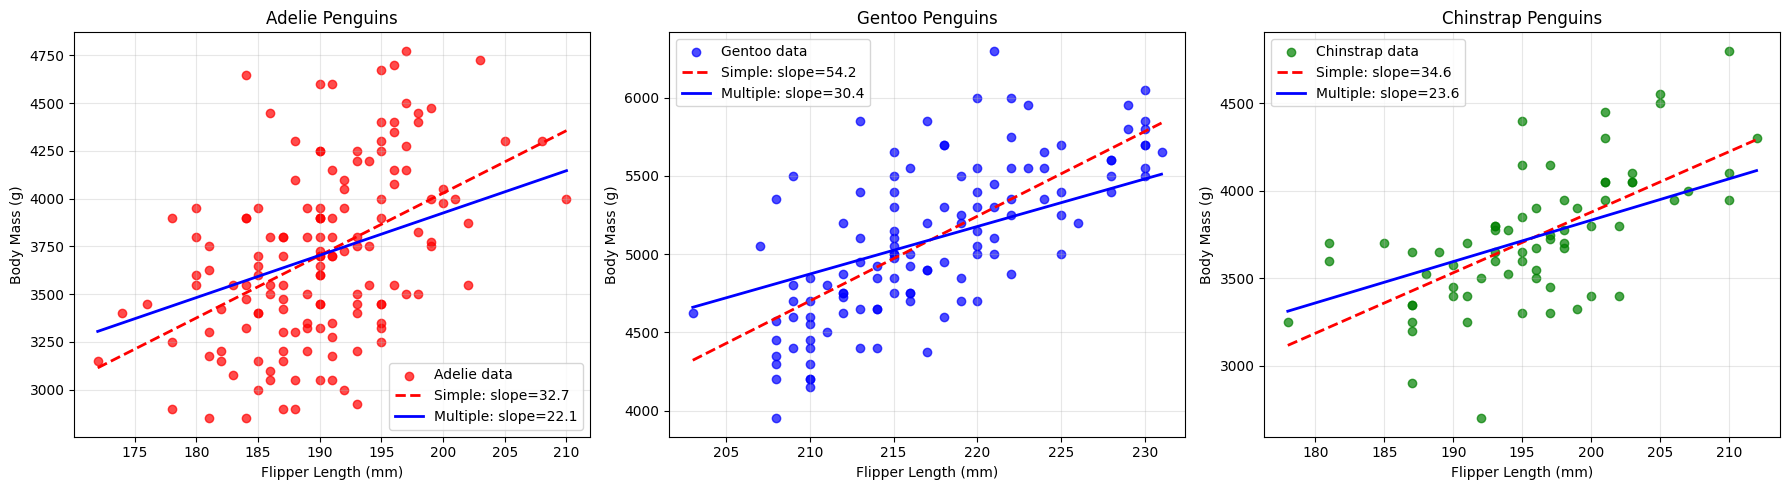

Coefficient Comparison by Species:
Adelie:
  Simple regression slope: 32.69
  Multiple regression slope: 22.15
  Change: -10.54

Gentoo:
  Simple regression slope: 54.17
  Multiple regression slope: 30.39
  Change: -23.78

Chinstrap:
  Simple regression slope: 34.57
  Multiple regression slope: 23.63
  Change: -10.95



In [6]:
# Show why coefficients change by looking at species separately
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

species_list = ['Adelie', 'Gentoo', 'Chinstrap']
colors = ['red', 'blue', 'green']

for i, species in enumerate(species_list):
    species_data = penguins_clean[penguins_clean['species'] == species]
    
    # Simple regression for this species
    simple_species = ols("body_mass_g ~ flipper_length_mm", data=species_data).fit()
    
    # Multiple regression for this species
    multiple_species = ols("body_mass_g ~ flipper_length_mm + bill_depth_mm", data=species_data).fit()
    
    # Plot
    axes[i].scatter(species_data['flipper_length_mm'], species_data['body_mass_g'], 
                   color=colors[i], alpha=0.7, label=f'{species} data')
    
    # Simple regression line
    flipper_range = np.linspace(species_data['flipper_length_mm'].min(), 
                               species_data['flipper_length_mm'].max(), 100)
    simple_pred = simple_species.params['Intercept'] + simple_species.params['flipper_length_mm'] * flipper_range
    axes[i].plot(flipper_range, simple_pred, '--', color='red', linewidth=2, 
                 label=f'Simple: slope={simple_species.params["flipper_length_mm"]:.1f}')
    
    # Multiple regression line (at mean bill depth for this species)
    mean_bill_depth = species_data['bill_depth_mm'].mean()
    multiple_pred = (multiple_species.params['Intercept'] + 
                    multiple_species.params['flipper_length_mm'] * flipper_range + 
                    multiple_species.params['bill_depth_mm'] * mean_bill_depth)
    axes[i].plot(flipper_range, multiple_pred, '-', color='blue', linewidth=2, 
                 label=f'Multiple: slope={multiple_species.params["flipper_length_mm"]:.1f}')
    
    axes[i].set_xlabel('Flipper Length (mm)')
    axes[i].set_ylabel('Body Mass (g)')
    axes[i].set_title(f'{species} Penguins')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Show the coefficient comparison
print("Coefficient Comparison by Species:")
print("="*50)
for species in species_list:
    species_data = penguins_clean[penguins_clean['species'] == species]
    simple_species = ols("body_mass_g ~ flipper_length_mm", data=species_data).fit()
    multiple_species = ols("body_mass_g ~ flipper_length_mm + bill_depth_mm", data=species_data).fit()
    
    print(f"{species}:")
    print(f"  Simple regression slope: {simple_species.params['flipper_length_mm']:.2f}")
    print(f"  Multiple regression slope: {multiple_species.params['flipper_length_mm']:.2f}")
    print(f"  Change: {multiple_species.params['flipper_length_mm'] - simple_species.params['flipper_length_mm']:.2f}")
    print()


## Key Takeaways

### What "Holding Constant" Means:

1. **Partial Effect**: The coefficient in multiple regression represents the effect of one variable **while controlling for** other variables
2. **Visual Understanding**: Each slice of the regression plane has the same slope - this IS the partial effect
3. **Why Coefficients Change**: Simple regression confounds the effect of one variable with correlated variables

### Business Interpretation:

- **Simple regression**: "Longer flippers → heavier penguins" (but this mixes species effects)
- **Multiple regression**: "Longer flippers → heavier penguins, **holding bill depth constant**" (isolates the flipper effect)

### When to Use Multiple Regression:

- **Confounding variables** present (like species differences)
- **Correlated predictors** that might influence each other
- **Need to isolate** the effect of one specific variable
- **Simpson's paradox** is suspected (relationships reverse when controlling for other variables)
